In [152]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from sklearn.pipeline import make_pipeline

%matplotlib inline

In [153]:
# Dataset gotten from 
# https://www.kaggle.com/api/v1/datasets/download/wardabilal/real-estate-price-insights

In [154]:
df = pd.read_csv('housing_price_data.csv')

In [155]:
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [156]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [157]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

price
[13300000 12250000 12215000 11410000 10850000]
219

area
[7420 8960 9960 7500 8580]
284

bedrooms
[4 3 5 2 6]
6

bathrooms
[2 4 1 3]
4

stories
[3 4 2 1]
4

mainroad
['yes' 'no']
2

guestroom
['no' 'yes']
2

basement
['no' 'yes']
2

hotwaterheating
['no' 'yes']
2

airconditioning
['yes' 'no']
2

parking
[2 3 0 1]
4

prefarea
['yes' 'no']
2

furnishingstatus
['furnished' 'semi-furnished' 'unfurnished']
3



<Axes: xlabel='price', ylabel='Count'>

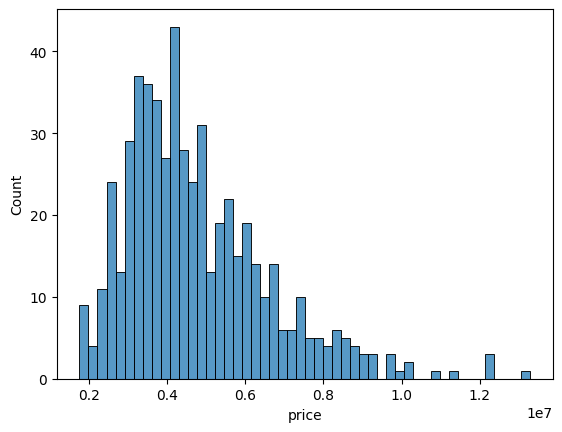

In [158]:
# Check the target variable

sns.histplot(df.price, bins=50)

<Axes: xlabel='price', ylabel='Count'>

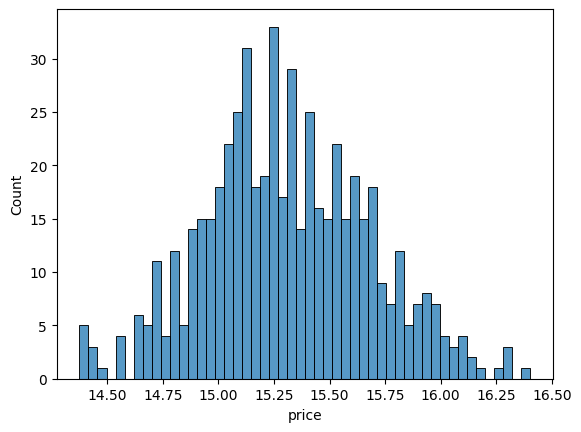

In [159]:
# We will need to use a log distribution due to the shape of the distribution

price_logs = np.log1p(df.price)
sns.histplot(price_logs, bins=50)

In [160]:
# Now let's split the data

from sklearn.model_selection import train_test_split

In [161]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=25)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=25)

len(df_train), len(df_val), len(df_test)

(327, 109, 109)

In [162]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [163]:
y_train = np.log1p(df_train.price.values)
y_test = np.log1p(df_test.price.values)
y_val = np.log1p(df_val.price.values)

In [164]:
del df_train['price']
del df_test['price']
del df_val['price']

In [165]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

train_dicts

[{'area': 4040,
  'bedrooms': 2,
  'bathrooms': 1,
  'stories': 1,
  'mainroad': 'yes',
  'guestroom': 'no',
  'basement': 'no',
  'hotwaterheating': 'no',
  'airconditioning': 'no',
  'parking': 0,
  'prefarea': 'no',
  'furnishingstatus': 'unfurnished'},
 {'area': 7424,
  'bedrooms': 3,
  'bathrooms': 1,
  'stories': 1,
  'mainroad': 'no',
  'guestroom': 'no',
  'basement': 'no',
  'hotwaterheating': 'no',
  'airconditioning': 'no',
  'parking': 0,
  'prefarea': 'no',
  'furnishingstatus': 'unfurnished'},
 {'area': 7085,
  'bedrooms': 3,
  'bathrooms': 1,
  'stories': 1,
  'mainroad': 'yes',
  'guestroom': 'yes',
  'basement': 'yes',
  'hotwaterheating': 'no',
  'airconditioning': 'no',
  'parking': 2,
  'prefarea': 'yes',
  'furnishingstatus': 'semi-furnished'},
 {'area': 2400,
  'bedrooms': 3,
  'bathrooms': 1,
  'stories': 2,
  'mainroad': 'yes',
  'guestroom': 'no',
  'basement': 'no',
  'hotwaterheating': 'no',
  'airconditioning': 'no',
  'parking': 0,
  'prefarea': 'no',
  'fu

In [166]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

In [167]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [168]:
# Correlate with price

numerical = ['area','bedrooms','bathrooms','stories', 'parking']
df_full_train[numerical].corrwith(df_full_train.price)

area         0.554417
bedrooms     0.364166
bathrooms    0.535365
stories      0.419885
parking      0.372753
dtype: float64

In [169]:
from sklearn.linear_model import LinearRegression

In [170]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [171]:
y_pred = model.predict(X_val)

In [172]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [173]:
rmse(y_val, y_pred)

np.float64(0.22243966753133662)

In [174]:
# Implement XGBoost
import xgboost as xgb

In [175]:
def tune_xgbregressor(x_train, x_test, max_depth=2, n_estimators=10, learning_rate=0.2):
    model = xgb.XGBRegressor(objective='reg:squarederror', 
                             max_depth=max_depth, 
                             learning_rate=learning_rate,
                             n_estimators=n_estimators,
                             random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return rmse(y_val, y_pred)

In [176]:
# Tune learning rate
learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

print("Learning rate results")
for l in learning_rate:
    print("{} -> {}".format(l,tune_xgbregressor(X_train, X_val, learning_rate=l)))

Learning rate results
0.1 -> 0.28012236977362426
0.2 -> 0.24408191821323247
0.3 -> 0.23289892607954674
0.4 -> 0.2264003454050633
0.5 -> 0.22053068787706823
0.6 -> 0.22615916615495826
0.7 -> 0.2372879070283041
0.8 -> 0.24805098802451186
0.9 -> 0.2557946985944302
1.0 -> 0.25686589025667106


In [177]:
# Fix learning_rate
learning_rate = 0.5

In [178]:
# Tune max_depth
max_depth = [2,5,6,10,15,20]

print("Max depth results")
for m in max_depth:
    print("{} -> {}".format(m, tune_xgbregressor(X_train, X_val, 
                                                learning_rate=learning_rate,
                                                max_depth=m)))

Max depth results
2 -> 0.22053068787706823
5 -> 0.2569573312772234
6 -> 0.2657876204781928
10 -> 0.2896955510212066
15 -> 0.2879222948074331
20 -> 0.2875056116849372


In [179]:
# Fix max_depth
max_depth = 2

In [180]:
# Tune n_estimators
n_estimators = [6,10,15,20,50,100]

print("Number of estimators results")
for n in n_estimators:
    print("{} -> {}".format(n, tune_xgbregressor(X_train, X_val, 
                                                learning_rate=learning_rate,
                                                max_depth=max_depth,
                                                n_estimators=n)))

Number of estimators results
6 -> 0.22426940686899385
10 -> 0.22053068787706823
15 -> 0.21975781220217142
20 -> 0.2195294755423438
50 -> 0.23552645429820843
100 -> 0.24152040028755362


In [181]:
# Fix n_estimators
n_estimators = 20

In [182]:
# Train model with full train
# We will use xgb since it is slightly better than linear regression

y_full_train = np.log1p(df_full_train.price.values)

In [183]:
del(df_full_train['price'])

In [184]:
dicts_full_train = df_full_train.to_dict(orient='records')
dicts_test = df_test.to_dict(orient='records')

pipeline = make_pipeline(
    DictVectorizer(),
    LinearRegression()
)

In [185]:
pipeline.fit(dicts_full_train, y_full_train)

,steps,"[('dictvectorizer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,True
,sort,True
,fit_intercept,True
,copy_X,True
,tol,1e-06


In [187]:
y_pred = pipeline.predict(dicts_test)
rmse(y_test, y_pred)

np.float64(0.2023955815320995)

In [188]:
dicts_full_train = df_full_train.to_dict(orient='records')
dicts_test = df_test.to_dict(orient='records')

pipeline = make_pipeline(
    DictVectorizer(),
    xgb.XGBRegressor(objective='reg:squarederror', 
                         max_depth=max_depth, 
                         learning_rate=learning_rate,
                         n_estimators=n_estimators,
                         random_state=42)
)

pipeline.fit(dicts_full_train, y_full_train)

,steps,"[('dictvectorizer', ...), ('xgbregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,True
,sort,True
,objective,'reg:squarederror'
,base_score,None
,booster,None


In [189]:
y_pred = pipeline.predict(dicts_test)
rmse(y_test, y_pred)

np.float64(0.20099409069407637)

In [199]:
output_file = 'pipeline.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump(pipeline, f_out)


print(f'the model is saved to {output_file}')

the model is saved to pipeline.bin


In [198]:
df_full_train.iloc[30].to_dict()

{'area': 3290,
 'bedrooms': 2,
 'bathrooms': 1,
 'stories': 1,
 'mainroad': 'yes',
 'guestroom': 'no',
 'basement': 'no',
 'hotwaterheating': 'yes',
 'airconditioning': 'no',
 'parking': 1,
 'prefarea': 'no',
 'furnishingstatus': 'furnished'}

In [202]:
np.expm1(y_full_train[30])

np.float64(3920000.000000001)